## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [1]:
EXPERIMENT_NAME='CNN/1_basic_cnn'
assert(not EXPERIMENT_NAME is None)

import tensorflow as tf
import uuid
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import warnings
import rasterio
import json
import glob
import shutil

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Activation, Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

%matplotlib inline
print(tf.config.list_physical_devices('GPU'))

2025-10-16 20:22:50.149143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-16 20:22:50.219173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-16 20:22:50.249378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 20:22:50.355042: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1760646174.077746    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760646174.322265    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760646174.322297    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
PROJECT_PATH = "/workspace/COMPUTERVISIONPROYECT"
DATASET_NAME = 'stratified'

# XVIEW_RECOGNITION_PATH = "./data/xview_recognition/"
XVIEW_RECOGNITION_PATH = os.path.join(PROJECT_PATH, "data/xview_recognition")

EXPERIMENT_PATH = os.path.join(PROJECT_PATH, "experiment_results", EXPERIMENT_NAME)
assert(not os.path.exists(EXPERIMENT_PATH))
if not os.path.exists(EXPERIMENT_PATH):
    os.mkdir(EXPERIMENT_PATH)
CHECKPOINT_DIR = os.path.join(EXPERIMENT_PATH, 'model_checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_WEIGHTS_FILENAME_PATTERN = os.path.join(CHECKPOINT_DIR, 'epoch_{epoch:03d}-val_loss_{val_loss:.4f}.keras')
MODEL_PATH = os.path.join(EXPERIMENT_PATH, 'model.keras')

TRAIN_SET_FILENAME = '_'.join([DATASET_NAME, 'train.tfrecord'])
VALIDATION_SET_FILENAME = '_'.join([DATASET_NAME, 'validation.tfrecord'])
TRAIN_SET_PATH = os.path.join(XVIEW_RECOGNITION_PATH, TRAIN_SET_FILENAME)
VALIDATION_SET_PATH = os.path.join(XVIEW_RECOGNITION_PATH, VALIDATION_SET_FILENAME)

## Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = None
DROPOUT_RATE = None
REGULARIZER_PENALTY = None
EPOCHS = 20

categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

# Required classes and functions

In [3]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3.2*pow(len(categories), 0.5), 2.4*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(15-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

# 0. La usamos para las imágenes de test
def load_geoimage(filename_tensor):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    filename = filename_tensor
    src_raster = rasterio.open(filename, 'r')

    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

# 1. Función para decodificar los ejemplos del archivo
def _parse_image_function(example_proto):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'category_id': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    
    features = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.decode_raw(features['image_raw'], out_type=tf.uint8)
    shape = [features['height'], features['width'], features['depth']]
    image = tf.reshape(image, shape)
    image = tf.cast(image, tf.float32)
    
    image = tf.image.resize(image, [224, 224])
    
    category_id = tf.cast(features['category_id'], tf.int32)
    label = tf.one_hot(category_id, depth=len(categories))
    
    return image, label

# 2. Función para crear el dataset
def create_tfrecord_dataset(filenames, batch_size, do_shuffle=False):
    # Lee los archivos TFRecord. Puede leer de múltiples archivos en paralelo.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    
    if do_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Datasets definition

In [5]:
train_dataset = create_tfrecord_dataset([TRAIN_SET_PATH], BATCH_SIZE, do_shuffle=True)
valid_dataset = create_tfrecord_dataset([VALIDATION_SET_PATH], BATCH_SIZE)

I0000 00:00:1760646177.126175    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760646177.126216    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760646177.126224    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760646177.304508    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760646177.304549    1819 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-16

In [6]:
y_train_labels = []
for _,label_idxs in train_dataset:
    y_train_labels += list(label_idxs.numpy().argmax(axis=1))

index,freqs = np.unique(y_train_labels, return_counts=True)
categories_count = pd.Series(freqs, index=[categories[idx] for idx in index], name='Size').sort_values(ascending=False)

categories_count

2025-10-16 20:23:05.795303: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Building              3235
Small car             2992
Truck                 1989
Bus                   1591
Shipping container    1371
Storage tank          1322
Dump truck            1112
Motorboat              962
Excavator              710
Fishing vessel         635
Cargo plane            571
Pylon                  281
Helipad                100
Name: Size, dtype: int64

# Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
model = Sequential(name=EXPERIMENT_NAME)

# 1. Capa de Entrada
model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), name='Pool1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), name='Pool2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), name='Pool3'))

model.add(Flatten(name='Flatten'))

model.add(Dense(len(categories), activation='softmax'))

model.summary()

Model: "CNN/1_basic_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1_32 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 Pool1 (MaxPooling2D)        (None, 112, 112, 32)      0         
                                                                 
 Conv2_64 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 Pool2 (MaxPooling2D)        (None, 56, 56, 64)        0         
                                                                 
 Conv3_128 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 Pool3 (MaxPooling2D)        (None, 28, 28, 128)       0         
                                                                 
 Flatten (Flatten)           (None, 100352)        

In [8]:
opt = Adam(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Callbacks
model_checkpoint = ModelCheckpoint(
    filepath=BEST_WEIGHTS_FILENAME_PATTERN,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
terminate = TerminateOnNaN()
early_stop = EarlyStopping('val_accuracy', patience=EPOCHS, verbose=1, restore_best_weights=False)
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [10]:
print('Training model')
h = model.fit(train_dataset, 
              validation_data=valid_dataset, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

checkpoints = glob.glob(os.path.join(CHECKPOINT_DIR, '*.keras'))

if checkpoints:
    # Copiamos el mejor modelo en la ruta {EXPERIMENT_PATH}/model.keras
    # Ordenar los archivos por el valor de 'val_loss' (que está en el nombre)
    # y coger el primero (el que tenga el valor más bajo)
    BEST_WEIGHTS_FILENAME = min(checkpoints, key=lambda x: float(x.split('val_loss_')[1].replace('.keras', '')))
    model.load_weights(BEST_WEIGHTS_FILENAME)
    model.save(MODEL_PATH)

    print(f"El mejor modelo se encuentra en: {MODEL_PATH}")
else:
    print("No se encontraron checkpoints.")

Training model
Epoch 1/20


2025-10-16 20:23:22.630823: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1760646202.869937    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646202.982932    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646203.080568    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646203.090714    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646203.095380    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646203.099829    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646203.118989    2637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646203.125884    2637 gpu_

      1/Unknown - 1s 975ms/step - loss: 8.9472 - accuracy: 0.0781

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1760646204.891606    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646204.894114    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646204.896368    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646204.900006    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646204.904122    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646204.908294    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646204.915358    2633 gpu_timer.cc:114] Skipping

      2/Unknown - 2s 952ms/step - loss: 58.9667 - accuracy: 0.1484

W0000 00:00:1760646205.703715    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.707270    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.710756    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.715109    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.719981    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.724533    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.729161    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.737587    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646205.746142    2633 gp

      3/Unknown - 2s 756ms/step - loss: 79.7275 - accuracy: 0.1198

W0000 00:00:1760646206.352752    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.369697    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.404370    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.406784    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.409085    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.412769    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.417233    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.421438    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.428134    2636 gp

      4/Unknown - 3s 691ms/step - loss: 81.9399 - accuracy: 0.1094

W0000 00:00:1760646206.773219    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.779013    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.804440    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.829601    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.833097    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.837412    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.841977    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.846908    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646206.851575    2634 gp

      5/Unknown - 3s 606ms/step - loss: 74.7537 - accuracy: 0.0984

W0000 00:00:1760646207.181098    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.184311    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.188461    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.192554    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.196587    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.201379    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.206740    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.213047    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.218940    2633 gp

      8/Unknown - 4s 412ms/step - loss: 52.1252 - accuracy: 0.1133

W0000 00:00:1760646207.588139    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646207.594014    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


    131/Unknown - 11s 77ms/step - loss: 5.0207 - accuracy: 0.3567

W0000 00:00:1760646214.839386    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.841381    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.843262    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.846226    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.850017    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.853438    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.858831    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.864240    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646214.869568    2634 gp

    132/Unknown - 12s 82ms/step - loss: 4.9988 - accuracy: 0.3575

W0000 00:00:1760646215.532266    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.535129    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.537843    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.541261    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.545204    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.548929    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.552692    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.559291    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646215.566483    2636 gp


Epoch 1: val_loss improved from inf to 1.67637, saving model to /workspace/COMPUTERVISIONPROYECT/experiment_results/CNN/1_basic_cnn/model_checkpoints/epoch_001-val_loss_1.6764.keras
132/132 [==============================] - 14s 98ms/step - loss: 4.9988 - accuracy: 0.3575 - val_loss: 1.6764 - val_accuracy: 0.4283 - lr: 0.0010
Epoch 2/20


2025-10-16 20:23:37.535509: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-16 20:23:37.535554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9812801411660402841
2025-10-16 20:23:37.535559: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1502698929952582131
2025-10-16 20:23:37.535576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 858379135782873116


131/132 [============================>.] - ETA: 0s - loss: 1.4949 - accuracy: 0.5036

W0000 00:00:1760646225.342341    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.344274    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.346105    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.349157    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.352641    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.356492    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.361912    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.367283    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646225.372712    2633 gp

132/132 [==============================] - ETA: 0s - loss: 1.4949 - accuracy: 0.5038

W0000 00:00:1760646226.003437    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.006375    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.009206    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.013082    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.016829    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.020513    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.024230    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.031134    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646226.038110    2631 gp


Epoch 2: val_loss improved from 1.67637 to 1.45366, saving model to /workspace/COMPUTERVISIONPROYECT/experiment_results/CNN/1_basic_cnn/model_checkpoints/epoch_002-val_loss_1.4537.keras
132/132 [==============================] - 9s 69ms/step - loss: 1.4949 - accuracy: 0.5038 - val_loss: 1.4537 - val_accuracy: 0.5109 - lr: 0.0010
Epoch 3/20
 91/132 [===================>..........] - ETA: 2s - loss: 1.3255 - accuracy: 0.5604

W0000 00:00:1760646231.714624    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.719263    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.723850    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.727394    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.730944    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.735256    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.740272    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.744672    2636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646231.749806    2636 gp


Epoch 3: val_loss did not improve from 1.45366
132/132 [==============================] - 6s 42ms/step - loss: 1.3045 - accuracy: 0.5688 - val_loss: 1.4724 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 4/20


W0000 00:00:1760646232.334004    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.339539    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.343675    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.346634    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.349545    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.352898    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.356937    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.361118    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646232.365207    2635 gp

132/132 [==============================] - ETA: 0s - loss: 1.1623 - accuracy: 0.6093

W0000 00:00:1760646240.073666    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.078471    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.083135    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.086700    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.090240    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.094287    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.099638    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.104042    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.109221    2635 gp


Epoch 4: val_loss improved from 1.45366 to 1.39832, saving model to /workspace/COMPUTERVISIONPROYECT/experiment_results/CNN/1_basic_cnn/model_checkpoints/epoch_004-val_loss_1.3983.keras


W0000 00:00:1760646240.685111    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.690616    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.694342    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.697207    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.700147    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.703568    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.707615    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.711384    2635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646240.715551    2635 gp

132/132 [==============================] - 8s 64ms/step - loss: 1.1623 - accuracy: 0.6093 - val_loss: 1.3983 - val_accuracy: 0.5541 - lr: 0.0010
Epoch 5/20
132/132 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.6489

W0000 00:00:1760646248.668728    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.671258    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.673239    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.675503    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.677759    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.679903    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.682450    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.685800    2631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646248.688062    2631 gp


Epoch 5: val_loss improved from 1.39832 to 1.39464, saving model to /workspace/COMPUTERVISIONPROYECT/experiment_results/CNN/1_basic_cnn/model_checkpoints/epoch_005-val_loss_1.3946.keras
132/132 [==============================] - 8s 64ms/step - loss: 1.0536 - accuracy: 0.6489 - val_loss: 1.3946 - val_accuracy: 0.5568 - lr: 0.0010


W0000 00:00:1760646249.153195    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.158623    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.162325    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.165158    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.168031    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.171549    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.175621    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.179427    2634 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646249.183561    2634 gp

Epoch 6/20
132/132 [==============================] - ETA: 0s - loss: 0.9852 - accuracy: 0.6680

W0000 00:00:1760646257.005063    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.007377    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.009372    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.011329    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.013429    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.015616    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.018722    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.022115    2638 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.024348    2638 gp


Epoch 6: val_loss did not improve from 1.39464
132/132 [==============================] - 8s 63ms/step - loss: 0.9852 - accuracy: 0.6680 - val_loss: 1.4918 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 7/20


W0000 00:00:1760646257.509475    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.515230    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.519049    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.521917    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.524797    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.528087    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.532526    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.536370    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646257.540433    2632 gp

132/132 [==============================] - ETA: 0s - loss: 0.9089 - accuracy: 0.6945

W0000 00:00:1760646262.602275    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.604561    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.606505    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.608510    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.610626    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.612741    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.615295    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.619331    2632 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646262.621706    2632 gp


Epoch 7: val_loss did not improve from 1.39464
132/132 [==============================] - 6s 42ms/step - loss: 0.9089 - accuracy: 0.6945 - val_loss: 1.4459 - val_accuracy: 0.5653 - lr: 0.0010
Epoch 8/20
  1/132 [..............................] - ETA: 8s - loss: 1.0176 - accuracy: 0.6641

W0000 00:00:1760646263.096121    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.101469    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.105445    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.108398    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.111322    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.115006    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.119135    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.122900    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646263.127040    2633 gp

132/132 [==============================] - ETA: 0s - loss: 0.8349 - accuracy: 0.7157

W0000 00:00:1760646270.826499    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.828752    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.830707    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.832732    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.835124    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.837233    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.839759    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.843091    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646270.845350    2633 gp


Epoch 8: val_loss did not improve from 1.39464
132/132 [==============================] - 8s 62ms/step - loss: 0.8349 - accuracy: 0.7157 - val_loss: 1.5649 - val_accuracy: 0.5472 - lr: 0.0010
Epoch 9/20
  1/132 [..............................] - ETA: 8s - loss: 0.8038 - accuracy: 0.7188

W0000 00:00:1760646271.315468    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.321091    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.324875    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.328077    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.330987    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.334336    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.338381    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.342183    2633 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1760646271.346653    2633 gp

131/132 [============================>.] - ETA: 0s - loss: 0.7988 - accuracy: 0.7281
Epoch 9: val_loss did not improve from 1.39464
132/132 [==============================] - 8s 61ms/step - loss: 0.7979 - accuracy: 0.7284 - val_loss: 1.6574 - val_accuracy: 0.5691 - lr: 0.0010
Epoch 10/20
124/132 [===========================>..] - ETA: 0s - loss: 0.7319 - accuracy: 0.7537
Epoch 10: val_loss did not improve from 1.39464
132/132 [==============================] - 5s 40ms/step - loss: 0.7296 - accuracy: 0.7533 - val_loss: 1.6683 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 11/20
131/132 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.7730
Epoch 11: val_loss did not improve from 1.39464
132/132 [==============================] - 8s 61ms/step - loss: 0.6692 - accuracy: 0.7735 - val_loss: 1.8093 - val_accuracy: 0.5637 - lr: 0.0010
Epoch 12/20
131/132 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.7855
Epoch 12: val_loss did not improve from 1.3946

# Validation
Compute validation metrics.

In [11]:
predictions = model.predict(valid_dataset)
category_names = np.array(list(categories.values()))
y_pred = category_names[predictions.argmax(axis=1)]

y_true = []

for images_batch, labels_batch in valid_dataset:
    labels_np = labels_batch.numpy()
    
    true_indices = np.argmax(labels_np, axis=1)
    batch_labels = category_names[true_indices]
    
    y_true.extend(batch_labels)

15/15 [==============================] - 1s 38ms/step


2025-10-16 20:29:13.748721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1502698929952582131
2025-10-16 20:29:13.872396: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


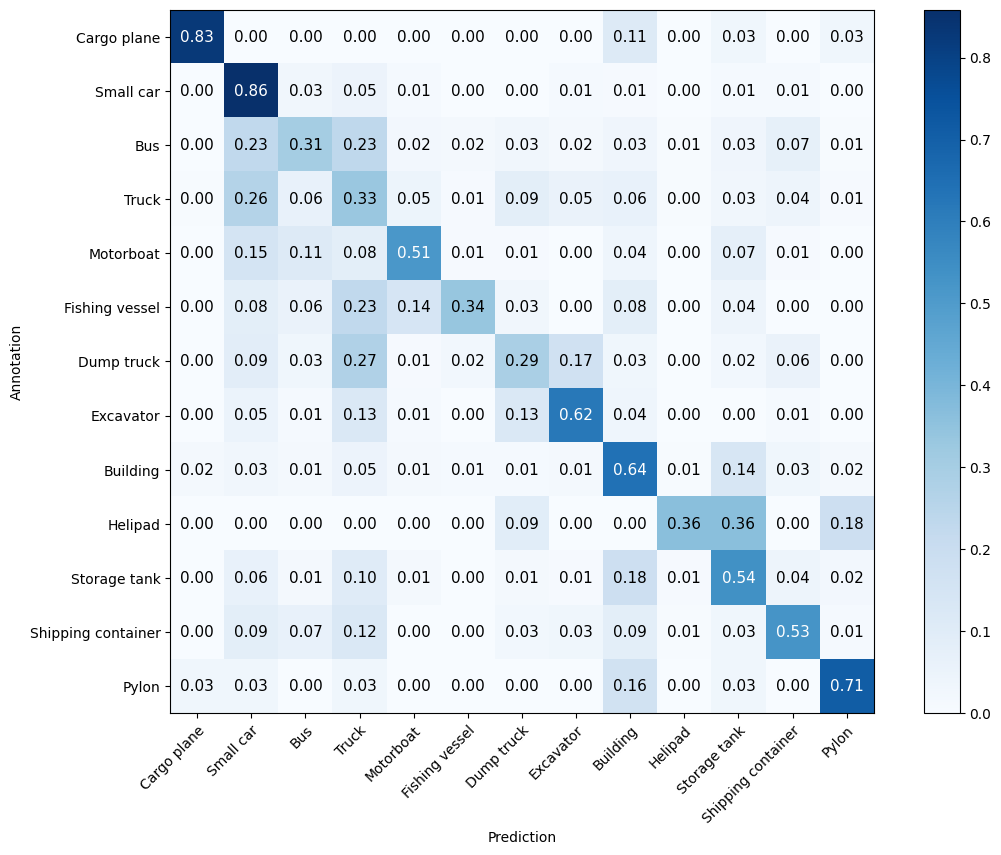

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [13]:
ll = []
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    ll.append(pd.Series([recall, precision, specificity, f1_score], name=categories[idx], index=["Recall", "Precision", "Specificity", "F1 Score"]))
ll = pd.DataFrame(ll)
ll = pd.concat([categories_count, ll, pd.Series([EXPERIMENT_NAME for _ in categories], name='Experiment', index=categories.values())],axis=1)
ll.index.name='Category'
ll = ll.reset_index().set_index(['Experiment','Category'])
ll

Mean Accuracy: 55.680%
Mean Recall: 52.787%
Mean Precision: 54.588%


Size    Recall  Precision  Specificity  \
Experiment      Category                                                     
CNN/1_basic_cnn Building            3235  0.640669   0.714286     0.939314   
                Small car           2992  0.858434   0.629139     0.891121   
                Truck               1989  0.330317   0.289683     0.891778   
                Bus                 1591  0.305085   0.465517     0.963486   
                Shipping container  1371  0.526316   0.601504     0.969240   
                Storage tank        1322  0.537415   0.461988     0.946759   
                Dump truck          1112  0.290323   0.423529     0.972016   
                Motorboat            962  0.514019   0.597826     0.979072   
                Excavator            710  0.620253   0.490000     0.971604   
                Fishing vessel       635  0.338028   0.631579     0.992239   
                Cargo plane          571  0.828125   0.854839     0.995030   
                Pylon                281  0.709677   0.536585     0.989696   
                Helipad              100  0.363636   0.400000     0.996781   

                                    F1 Score  
Experiment      Category                      
CNN/1_basic_cnn Building            0.675477  
                Small car           0.726115  
                Truck               0.308668  
                Bus                 0.368601  
                Shipping container  0.561404  
                Storage tank        0.496855  
                Dump truck          0.344498  
                Motorboat           0.552764  
                Excavator           0.547486  
                Fishing vessel      0.440367  
                Cargo plane         0.841270  
                Pylon               0.611111  
                Helipad             0.380952

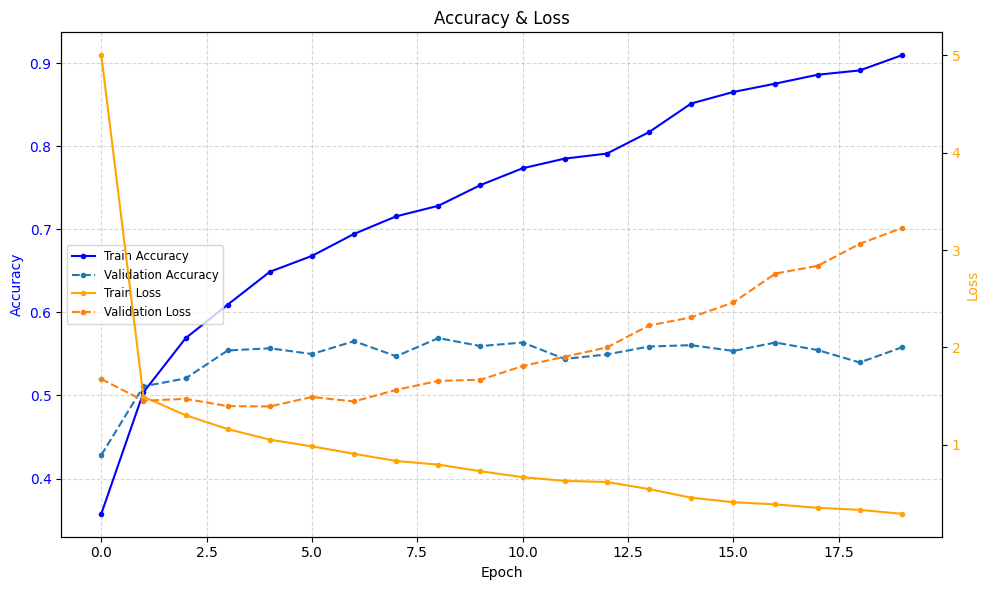

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))

plt.title('Accuracy & Loss')
ax1.set_xlabel('Epoch')

color_acc = 'blue'
ax1.set_ylabel('Accuracy', color=color_acc)
ax1.plot(h.history['accuracy'], label='Train Accuracy', color='blue', marker='.')
ax1.plot(h.history['val_accuracy'], label='Validation Accuracy', color='tab:blue', linestyle='--', marker='.')
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()  
color_loss = 'orange'
ax2.set_ylabel('Loss', color=color_loss)
ax2.plot(h.history['loss'], label='Train Loss', color='orange', marker='.')
ax2.plot(h.history['val_loss'], label='Validation Loss', color='tab:orange', linestyle='--', marker='.')
ax2.tick_params(axis='y', labelcolor=color_loss)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left', frameon=True, fontsize='small')

fig.tight_layout()
plt.show()

# Testing
Try to improve the results provided in the competition.

In [ ]:
anns = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(XVIEW_RECOGNITION_PATH, 'xview_recognition/xview_test')):
    for filename in filenames:
        image = GenericImage(os.path.join(dirpath,filename))
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

In [ ]:
model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)